- 데이터 분석 : 현재의 데이터로 미래를 예측하는 것이 목적
- 머신러닝을 하기 위한 데이터 가공을 배우며 고객 행동 분석, 파악하는 법을 학습

### 데이터
1. use_log.csv : 센터 이용 내력 (201804 ~ 201903)
2. customer_master.csv : 2019년 3월 말 시점의 회원 데이터 (탈퇴 회원 포함)
3. class_master.csv : 회원 구분 데이터
4. campaign_master.csv : 가입 시 행사 종류 데이터

### 테크닉 021 : 데이터를 읽어 들이고 확인하자

In [1]:
# 센터 이용 내력 데이터
import pandas as pd

uselog = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/3장/use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [2]:
# 회원 데이터
customer = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/3장/customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [3]:
# 회원 구분 데이터
class_master = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/3장/class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


In [4]:
# 행사 구분 데이터
campaign_master = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/3장/campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


- customer와 class_master, campaign_master는 각각 class, campaign_id로 결합 가능
- 분석을 위해 데이터를 가공. 기준이 되는 데이터를 결정해야 함
- customer, uselog를 이용할 수 있음
- 데이터 수가 더 적은 고객 데이터를 메인으로 진행, 후반에는 uselog를 중심으로 분석 진행

### 테크닉 022 : 고객 데이터를 가공하자

In [5]:
# customer + class_master + campaign_master
customer_join = pd.merge(customer, class_master, on = 'class', how = 'left')
customer_join = pd.merge(customer_join, campaign_master, on = 'campaign_id', how = 'left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [6]:
# 결측치 확인
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

- end_date의 결측치 : 회원의 탈퇴일이 공백이기 때문이라고 판단할 수 있음

### 테크닉 023 : 고객 데이터를 집계하자

In [7]:
# 회원 구분 데이터 집계
customer_join.groupby('class_name').count()['customer_id']

class_name
0_종일    2045
1_주간    1019
2_야간    1128
Name: customer_id, dtype: int64

In [8]:
# 행사 구분
customer_join.groupby('campaign_name').count()['customer_id']

campaign_name
0_입회비반액할인     650
1_입회비무료       492
2_일반         3050
Name: customer_id, dtype: int64

In [9]:
# 성별
customer_join.groupby('gender').count()['customer_id']

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [10]:
# 탈퇴 구분
customer_join.groupby('is_deleted').count()['customer_id']

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [11]:
# 20180401 이후에 가입한 회원 수 확인
customer_join['start_date'] = pd.to_datetime(customer_join['start_date'])
customer_start = customer_join.loc[customer_join['start_date'] > pd.to_datetime('20180401')]
print(len(customer_start))

1361


### 테크닉 024 : 최신 고객 데이터를 집계하자

- 가장 최근 월 (2019년 3월) 고객 데이터 파악
- 고객 데이터 : 탈퇴 고객 포함이므로 월별 집계와는 차이가 있음
- 최근 월 추출 방법 : 1) 2019년 3월에 탈퇴한 고객과 재적 중인 고객 추출 / 2) is_deleted 열로 추출
- 두 번째의 경우 2019년 3월에 탈퇴한 고객은 카운트되지 않으므로 첫 번째 방법 사용

In [12]:
# 대상 고객 추출 (customer_newer)
# 2019년 3월 31일 이후의 end date : 3월에 등록한 고객
customer_join["end_date"] = pd.to_datetime(customer_join["end_date"])
customer_newer = customer_join.loc[(customer_join["end_date"]>=pd.to_datetime("20190331"))|(customer_join["end_date"].isna())]
print(len(customer_newer))
customer_newer["end_date"].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [13]:
# 회원 구분 집계
customer_newer.groupby('class_name').count()['customer_id']

class_name
0_종일    1444
1_주간     696
2_야간     813
Name: customer_id, dtype: int64

In [14]:
# 행사 구분
customer_newer.groupby('campaign_name').count()['customer_id']

campaign_name
0_입회비반액할인     311
1_입회비무료       242
2_일반         2400
Name: customer_id, dtype: int64

In [15]:
# 성별 구분
customer_newer.groupby('gender').count()['customer_id']

gender
F    1400
M    1553
Name: customer_id, dtype: int64

- 전체 데이터 집계했을 때와 비율이 크게 다르지 않음 : 특정 회원 구분이나 성별이 탈퇴한 것이 아님
- 행사 구분의 경우(일반) : 전체 72%, 신입 회원 81% → 회원 비율 변화에 행사 구분이 영향을 줌
- 회원, 성별 구분은 큰 변화가 없으므로 이용 이력 데이터의 활용 검토
- 이용 이력 데이터 : 시간적인 요소 분석 가능 

### 테크닉 025 : 이용 이력 데이터를 집계하자

- 월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값, 정기적 이용 여부를 플래그로 작성, 고객 데이터에 추가

In [16]:
# 월 이용 횟수 집계
uselog['usedate'] = pd.to_datetime(uselog['usedate']) # 날짜타입으로 변환
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['연월', 'customer_id'], as_index = False).count() # 연월, 고객 ID별로 묶어 횟수 집계
uselog_months.rename(columns = {'log_id' : 'count'}, inplace = True)
del uselog_months['usedate']
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [17]:
# 고객별 평균값, 중앙값, 최댓값, 최솟값 집계
uselog_customer = uselog_months.groupby('customer_id').agg(['mean', 'median', 'max', 'min'])['count']
uselog_customer = uselog_customer.reset_index(drop = False)
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


### 테크닉 026 : 이용 이력 데이터로부터 정기 이용 플래그를 작성하자

- 스포츠 센터의 경우 정기적으로 센터를 이용하는 여부가 중요한 요소가 될 수 있음
- 판단은 주관적인 부분이나, 지금은 매주 같은 요일에 왔는지를 중심으로 판단
- 월/요일별로 집계 후, 최댓값이 4 이상인 요일이 하나라도 있는 회원의 경우 플래그를 1로 처리

In [18]:
# 월/요일별 집계
# weekday(): 요일 반환 (0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일)
uselog['weekday'] = uselog['usedate'].dt.weekday
uselog_weekday = uselog.groupby(['customer_id', '연월', 'weekday'], as_index = False).count()[['customer_id', '연월', 'weekday', 'log_id']]
uselog_weekday.rename(columns = {'log_id' : 'count'}, inplace = True)
uselog_weekday.head()

,customer_id,연월,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


- 회원 AS002855의 경우 2018년 4월 토요일에 4번, 5월에도 토요일에 4번을 방문
- 매주 토요일에 스포츠 센터에 방문한다고 추정 가능
- 회원별로 최댓값 계산, 그 최댓값이 4 이상인 경우(매주 특정 요일에 방문) 플래그를 지정

In [19]:
uselog_weekday = uselog_weekday.groupby('customer_id', as_index = False).max()[['customer_id', 'count']] # 회원별 최댓값(max())
uselog_weekday['routine_flg'] = 0 # 플래그 기본값을 0으로 설정
# where(조건식, 조건식을 만족하지 않을 경우의 출력값)
# count가 4 이상일 경우 값을 1로 변경
uselog_weekday['routine_flg'] = uselog_weekday['routine_flg'].where(uselog_weekday['count'] < 4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


### 테크닉 027 : 고객 데이터와 이용 이력 데이터를 결합하자

In [20]:
customer_join = pd.merge(customer_join, uselog_customer, on = 'customer_id', how = 'left')
# uselog_weekday의 경우 결합할 데이터를 customer_id와 routine_flg로 한정
customer_join = pd.merge(customer_join, uselog_weekday[['customer_id', 'routine_flg']], on = 'customer_id', how = 'left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1


In [21]:
# 결측치 확인
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

- end_date 외에는 결측치가 존재하지 않음
- 회원 데이터와 이용 이력이 결합되었으므로 고객 분석이 가능해졌음
- 마지막으로 회원 기간 칼럼을 하나 더 추가

### 테크닉 028 : 회원 기간을 계산하자

- 회원 기간 : start_date와 end_date의 차이
- 2019년 3월까지 탈퇴하지 않은 회원의 경우 end_date에 결측치가 존재
- 이 경우 end_date를 2019년 4월 30일로 보간하여 계산

In [23]:
# 월 집계
from dateutil.relativedelta import relativedelta # 날짜 비교 함수 라이브러리 임포트

customer_join['calc_date'] = customer_join['end_date']
# 결측치를 20190430으로 보간
customer_join['calc_date'] = customer_join['calc_date'].fillna(pd.to_datetime('20190430')) 
customer_join['membership_period'] = 0
for i in range(len(customer_join)):
  delta = relativedelta(customer_join['calc_date'].iloc[i], customer_join['start_date'].iloc[i])
  customer_join['membership_period'].iloc[i] = delta.years*12 + delta.months # 기간을 월단위로 계산
customer_join.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


### 테크닉 029 : 고객 행동의 각종 통계량을 파악하자

In [25]:
customer_join[['mean', 'median', 'max', 'min']].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [27]:
# 플래그 집계
customer_join.groupby('routine_flg').count()['customer_id']

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

- 1이 훨씬 많음 : 정기적으로 이용하는 회원의 수가 더 많음을 의미

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

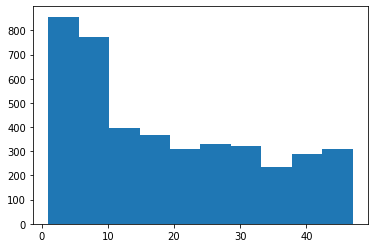

In [29]:
# 회원 기간 분포
import matplotlib.pyplot as plt
%matplotlib inline

# 히스토그램 이용
plt.hist(customer_join['membership_period'])

- 회원 기간이 10개월 이내인 회원이 많음
- 10개월 이상은 대체로 일정한 편
- 10개월 정도 이후로는 상당 수 탈퇴한다는 것을 의미

### 테크닉 030 : 탈퇴 회원과 지속 회원의 차이를 파악하자

- 테크닉 023에서 확인한 결과 : 탈퇴 회원 1350명, 지속 회원 2840명

In [30]:
# 탈퇴 회원과 지속 회원을 나눠서 비교
# 탈퇴 회원
customer_end = customer_join.loc[customer_join['is_deleted'] == 1]
customer_end.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,23.000000


In [32]:
# 지속 회원
customer_stay = customer_join.loc[customer_join['is_deleted'] == 0]
customer_stay.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,47.000000


- routine_flg의 평균값 경우 지속 회원은 0.98, 탈퇴 회원은 0.45 정도로 절반 정도는 랜덤하게 센터를 방문한다고 판단

In [33]:
# csv 파일로 저장
customer_join.to_csv('/content/drive/My Drive/pyda100/pyda100-master/3장/customer_join', index = False)